<a href="https://colab.research.google.com/github/Likhithagandham/Student-Training-Program/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving synthetic_creditcard.csv to synthetic_creditcard (5).csv
shape: (10000, 9)
Class
0    9871
1     129
Name: count, dtype: int64

BalancedRandomForest ROC-AUC: 0.4642
BalancedRandomForest PR-AUC : 0.012
BRF best threshold: 0.39 F1: 0.0295
Confusion matrix (BRF, tuned):
 [[998 976]
 [ 11  15]]
              precision    recall  f1-score   support

           0     0.9891    0.5056    0.6691      1974
           1     0.0151    0.5769    0.0295        26

    accuracy                         0.5065      2000
   macro avg     0.5021    0.5412    0.3493      2000
weighted avg     0.9764    0.5065    0.6608      2000


EasyEnsemble ROC-AUC: 0.5347
EasyEnsemble PR-AUC : 0.0158
EEC best threshold: 0.5521 F1: 0.0365
Confusion matrix (EEC, tuned):
 [[1785  189]
 [  22    4]]
              precision    recall  f1-score   support

           0     0.9878    0.9043    0.9442      1974
           1     0.0207    0.1538    0.0365        26

    accuracy                         0.8945      2000


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:29:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


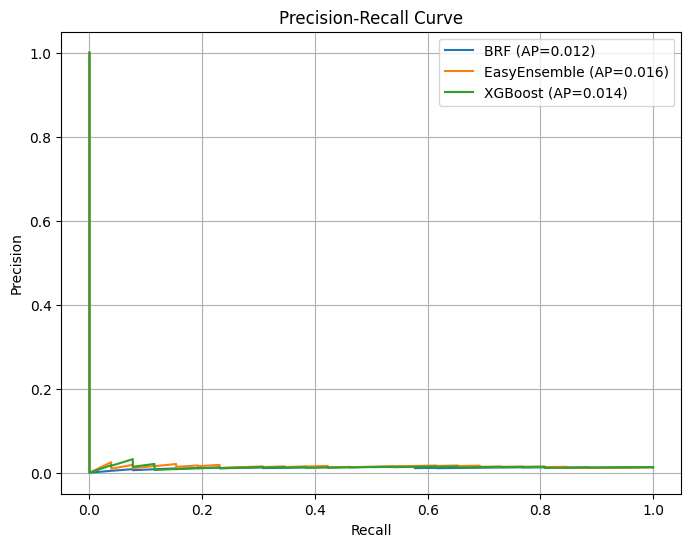


Pred counts (BRF tuned): [1009  991]
Pred counts (EEC tuned): [1807  193]
Pred counts (XGB tuned): [1938   62]


In [12]:
# Colab-ready: balanced models + threshold tuning + PR/ROC metrics
!pip install -q imbalanced-learn xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc, f1_score

# upload file
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)
print("shape:", df.shape)
print(df['Class'].value_counts())

# features & target
X = df.drop(columns=['Class'])
y = df['Class']

# stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ---------- BalancedRandomForest ----------
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
brf.fit(X_train, y_train)

y_proba_brf = brf.predict_proba(X_test)[:,1]
print("\nBalancedRandomForest ROC-AUC:", round(roc_auc_score(y_test, y_proba_brf),4))
print("BalancedRandomForest PR-AUC :", round(average_precision_score(y_test, y_proba_brf),4))

# pick threshold by maximizing F1 on validation/test
prec, rec, th = precision_recall_curve(y_test, y_proba_brf)
f1_scores = 2*prec*rec/(prec+rec+1e-12)
best_idx = np.nanargmax(f1_scores)
best_thr = th[best_idx] if best_idx < len(th) else 0.5
y_pred_thr = (y_proba_brf >= best_thr).astype(int)
print("BRF best threshold:", round(best_thr,4), "F1:", round(f1_scores[best_idx],4))
print("Confusion matrix (BRF, tuned):\n", confusion_matrix(y_test, y_pred_thr))
print(classification_report(y_test, y_pred_thr, digits=4))

# ---------- EasyEnsembleClassifier ----------
from imblearn.ensemble import EasyEnsembleClassifier
eec = EasyEnsembleClassifier(n_estimators=10, random_state=42, n_jobs=-1)
eec.fit(X_train, y_train)

# EasyEnsemble returns an ensemble that supports predict_proba
y_proba_eec = eec.predict_proba(X_test)[:,1]
print("\nEasyEnsemble ROC-AUC:", round(roc_auc_score(y_test, y_proba_eec),4))
print("EasyEnsemble PR-AUC :", round(average_precision_score(y_test, y_proba_eec),4))

prec2, rec2, th2 = precision_recall_curve(y_test, y_proba_eec)
f1_scores2 = 2*prec2*rec2/(prec2+rec2+1e-12)
best_idx2 = np.nanargmax(f1_scores2)
best_thr2 = th2[best_idx2] if best_idx2 < len(th2) else 0.5
y_pred_eec = (y_proba_eec >= best_thr2).astype(int)
print("EEC best threshold:", round(best_thr2,4), "F1:", round(f1_scores2[best_idx2],4))
print("Confusion matrix (EEC, tuned):\n", confusion_matrix(y_test, y_pred_eec))
print(classification_report(y_test, y_pred_eec, digits=4))

# ---------- Optional: XGBoost with scale_pos_weight (baseline) ----------
from xgboost import XGBClassifier
neg = (y_train==0).sum()
pos = (y_train==1).sum()
scale_pos_weight = max(1, neg/pos)
xgb = XGBClassifier(eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=42, use_label_encoder=False)
xgb.fit(X_train, y_train)
y_proba_xgb = xgb.predict_proba(X_test)[:,1]
print("\nXGBoost ROC-AUC:", round(roc_auc_score(y_test, y_proba_xgb),4))
print("XGBoost PR-AUC :", round(average_precision_score(y_test, y_proba_xgb),4))

# threshold tune XGBoost (same method)
prec3, rec3, th3 = precision_recall_curve(y_test, y_proba_xgb)
f1_scores3 = 2*prec3*rec3/(prec3+rec3+1e-12)
best_idx3 = np.nanargmax(f1_scores3)
best_thr3 = th3[best_idx3] if best_idx3 < len(th3) else 0.5
y_pred_xgb = (y_proba_xgb >= best_thr3).astype(int)
print("XGB best threshold:", round(best_thr3,4), "F1:", round(f1_scores3[best_idx3],4))
print("Confusion matrix (XGB, tuned):\n", confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, digits=4))

# ---------- Plot Precision-Recall curves ----------
plt.figure(figsize=(8,6))
plt.plot(rec, prec, label=f'BRF (AP={average_precision_score(y_test,y_proba_brf):.3f})')
plt.plot(rec2, prec2, label=f'EasyEnsemble (AP={average_precision_score(y_test,y_proba_eec):.3f})')
plt.plot(rec3, prec3, label=f'XGBoost (AP={average_precision_score(y_test,y_proba_xgb):.3f})')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve'); plt.legend(); plt.grid(True)
plt.show()

# ---------- Quick counts to avoid "undefined metric" warning ----------
print("\nPred counts (BRF tuned):", np.bincount(y_pred_thr))
print("Pred counts (EEC tuned):", np.bincount(y_pred_eec))
print("Pred counts (XGB tuned):", np.bincount(y_pred_xgb))
